# Circular Regression: Predicting Wind Direction using Von Mises NLL

## Introduction

In this exercise, we will build a **univariate circular regression model** to predict **wind direction** from meteorological features such as temperature, humidity, and wind speed. Even though the MLP itself is just a standard feedforward network, the combination of **output interpretation** and the **circular Von Mises loss function** makes it a circular regressor.

Unlike standard regression problems, **wind direction is a circular variable** (measured in radians from -π to π). This means that conventional losses like Mean Squared Error are not ideal, because the output “wraps around” at the boundaries. For example, -π and π represent the same direction.  

To handle this, we will use the **Von Mises Negative Log-Likelihood (NLL)** as the loss function which was dervied in the pen and paper exercise. 

### Model Overview

We will implement a **simple feedforward neural network (MLP)**:

- **Input:** Meteorological features (`temperature`, `humidity`, `wind_speed`)  
- **Hidden layers:** 2 layers with ReLU activation  
- **Output:** Single neuron predicting the **mean wind direction μ**  
- **Loss function:** Von Mises NLL  

## **Stages**

1. **Load & Visualize Data** – Inspect features and circular target distribution.  
2. **Define Model** – Implement an MLP with 2 hidden layers predicting mean direction μ.  
3. **Implement Loss** – Von Mises Negative Log-Likelihood.  
4. **Train model**  
5. **Evaluate model &Visualize Predictions** –  evaluate using **Mean Angular Error (MAE)** & Polar plot comparison of predicted vs true wind directions; check for underfitting or overfitting.


This notebook is organized into multiple blocks, each focusing on a specific part of the workflow. Your task is to build a circular regression model from scratch. Complete the missing sections of code, which are indicated by begin and end solution.


**Deliverables:** <br>

Submit the completed notebook (Exercise1.ipynb) and your trained model (best_model.pth) to moodle. 
Do not change the name of the notebook file. It may result in 0 points for the exercise.

In [ ]:
# Do not delete this cell

In [1]:
# Import necessary libraries

# Standard libraries
import math

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# From scikit learn import the built in train_test_split function
from sklearn.model_selection import train_test_split

# For mocking in test cases
from unittest.mock import patch, MagicMock

# Optional: For reproducibility
import random

# Set seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


In [15]:
skip_training = False 

In [ ]:
# Do not delete this cell

### Select Device for Computation

This code automatically selects the best available device for PyTorch computations:

- **MPS**: For Apple Silicon GPUs (if available).  
- **CUDA**: For NVIDIA GPUs (if available).  
- **CPU**: Falls back if no GPU is detected.  

The selected device is printed to confirm which one will be used.


In [2]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

mps


# **1. Load and Visualize Data**

In this section, we will load the synthetic wind dataset and perform basic visualization to understand the input features and the circular target variable `wind_direction`.

**Objectives:**

- Load the dataset into a Pandas DataFrame.  
- Inspect the first few rows and column names.  
- Visualize the distribution of the target variable `wind_direction`.

   temperature   humidity  wind_speed  wind_direction
0    16.116262  52.767215    4.857331        0.756740
1    27.063572  58.193625    4.327857        0.551954
2    22.907885  84.109223    2.290001       -0.080175
3    20.374511  49.120298    7.894467        0.650051
4    11.964354  85.136179    6.196114       -1.024251


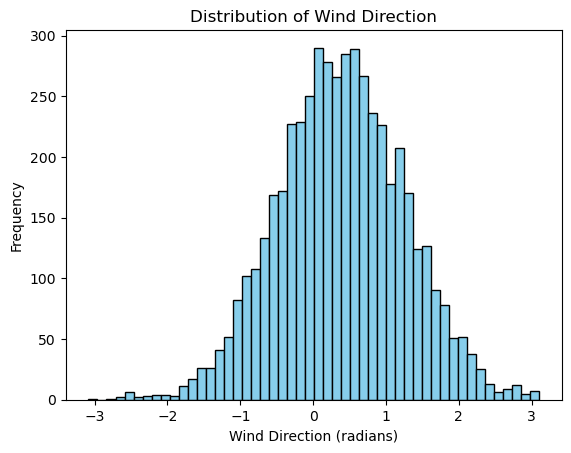

In [3]:

# Load the dataset
data = pd.read_csv("./wind_direction_data_5000.csv")

# Display first 5 rows
print(data.head())

# Plot histogram of wind direction
plt.hist(data['wind_direction'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Wind Direction (radians)')
plt.ylabel('Frequency')
plt.title('Distribution of Wind Direction')
plt.show()


## **2. Define the Circular MLP Model**. 

In this stage, you will define a **Multi-Layer Perceptron (MLP)** to predict the **mean wind direction** (μ_pred).  
The network should take meteorological features such as temperature, humidity, and wind speed as input.

The model will consist of:

- An **input layer** that receives the feature vector.  
- Two **hidden layers** with ReLU activations for non-linearity.  
- A single **output neuron** that predicts the mean wind direction.

**Task:** 

Complete the missing parts in the code below.

-- Model architecture
- Refer to the model architecture diagram below and implement the __init__ method of the CircularMLP class accordingly.




# CircularMLP Architecture

Below is the diagram showing the model architecture for circular regression:

<div style="text-align: center;">
    <img src="MLP_model_architecture.png" alt="CircularMLP Architecture" width="800">
</div>

In [4]:

class CircularMLP(nn.Module):
    def __init__(self, input_dim):
        """
        Initialize the CircularMLP model.

        Parameters:
            input_dim (int): Number of input features.

        """
        super().__init__()  # Initialize parent class

        # input_dim -> 64 -> 32 -> 1 
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        """
        Forward pass for the MLP
        
        Parameters:
            x: input tensor of shape (batch_size, input_dim)
        Returns:
            predicted_mu: tensor of shape (batch_size, 1)
        """
        
        x = self.fc1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        
        predicted_mu = self.output(x)
        return predicted_mu
        

In [5]:
#visible test cases for CircularMLP


# For mocking in test cases
from unittest.mock import patch, MagicMock

# --- Test cases begin ---
feedback_txt = []
all_tests_successful = True
linear_layer_count = 0
relu_layer_count = 0

input_dim = 3
model = CircularMLP(input_dim=input_dim)

# Count Linear and ReLU layers
for layer in model.modules():
    if isinstance(layer, nn.Linear):
        linear_layer_count += 1
    if isinstance(layer, nn.ReLU):
        relu_layer_count += 1

# --- Visible test 1: Check total Linear layers ---
if linear_layer_count != 3:
    all_tests_successful = False
    feedback_txt.append(f"Expected 3 Linear layers (fc1, fc2, output), but found {linear_layer_count}.")
    raise AssertionError(f"Expected 3 Linear layers, got {linear_layer_count}.")

# --- Visible test 2: Check total ReLU layers ---
if relu_layer_count != 2:
    all_tests_successful = False
    feedback_txt.append(f"Expected 2 ReLU layers (relu1, relu2), but found {relu_layer_count}.")
    raise AssertionError(f"Expected 2 ReLU layers, got {relu_layer_count}.")


dummy_input = torch.randn(4, input_dim)
dummy_output = model(dummy_input)


# --- Visible test 3: Ensure model runs end-to-end ---
try:
    _ = model(dummy_input)
except Exception as e:
    all_tests_successful = False
    feedback_txt.append(f"Forward pass failed: {str(e)}")
    raise AssertionError("Forward pass failed unexpectedly.")

# --- Visible test 4: Forward pass output shape ---


if dummy_output.shape != (4, 1):
    all_tests_successful = False
    feedback_txt.append(f"Expected output shape (4, 1), but got {dummy_output.shape}.")
    raise AssertionError(f"Expected output shape (4, 1), got {dummy_output.shape}.")


# --- Final feedback ---
if all_tests_successful:
    success_str = "All visible tests passed successfully!"
    print(f"\033[92m{success_str}\033[0m")
else:
    print("Some tests failed:")
    for fb in feedback_txt:
        print(f"- {fb}")


All visible tests passed successfully!


In [6]:

# This cell contains hidden test cases that will be evaluated after submission. DO NOT DELETE THE CELL.

## **3. Defining the Von Mises Negative Log-Likelihood (NLL)** 

The Von Mises distribution's probability density function is given below:

**p(y | μ, κ) = (1 / (2π * I₀(κ))) * exp(κ * cos(y - μ))**

here:
- **y** = observed wind direction (in radians)  
- **μ** = predicted mean direction  
- **κ** = concentration parameter (controls spread).
- **I₀(κ)** = modified Bessel function of the first kind, order 0  


We use a fixed concentration parameter **(κ)** = 3.5



In [7]:

def von_mises_nll(mu_pred, y_true, kappa=3.5):
    """
    Compute the Von Mises Negative Log-Likelihood (NLL)
    
    Parameters:
        mu_pred: predicted mean direction (tensor)
        y_true: true wind direction (tensor)
        kappa: concentration parameter (float)
        
    Returns:
        loss: scalar tensor representing average NLL
    """
    nll = -kappa * torch.cos(y_true - mu_pred) + torch.log(torch.special.i0(torch.tensor(kappa)))
    return nll.mean()


## **4a. Implement the Training Loop**

Now that your model and loss function are ready, let’s define a reusable **training function**.

This function should:

- Set the model to **training mode** (`model.train()`),
- Loop through batches from the training set,
- Perform **forward pass** to get predicted mean directions,
- Compute the **Von Mises NLL loss**,
- Perform **backpropagation** and **update model parameters** using the optimizer,
- Track and print the **average loss** for each epoch.

**Task:** Complete the missing code in the template below.

- Zero out gradients at the start of each batch.
- Pass the input features to the model to get predictions.
- Compute the NLL loss between predicted and true wind directions.
- Backpropagate the gradients and update the model weights.
- Append the batch loss to the `epoch_loss` list.

In [8]:
def train(model, optimizer, criterion, train_loader, num_epochs=50, verbose=True):
    """
    Function to train the model.
    
    Parameters:
    - model: The neural network model.
    - optimizer: The optimizer for parameter updates.
    - criterion: The Von Mises NLL loss function.
    - train_loader: DataLoader for training data.
    - num_epochs: Number of epochs (default = 50).
    - verbose: Print training progress (default = True).
    """
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = []

        for Xb, yb in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            # Forward pass
            mu_pred = model(Xb)
            # Compute loss
            loss = criterion(mu_pred, yb)
            # Backward pass
            loss.backward()
            # Update parameters
            optimizer.step()
            epoch_loss.append(loss.item())
            
        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Avg Loss: {np.mean(epoch_loss):.4f}")


In [9]:
# Visible Test Case for train()

feedback_txt = []
all_tests_successful = True

# Dummy model, optimizer, and loss for testing
class DummyModel(torch.nn.Module):
    def __init__(self, input_dim=3):
        super().__init__()
        self.fc = torch.nn.Linear(input_dim, 1)  # learnable parameter

    def forward(self, x):
        return self.fc(x)


model_dummy = DummyModel()
optimizer = torch.optim.SGD(model_dummy.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Mock train loader
mock_train_loader = MagicMock()
mock_train_loader.__iter__.return_value = [(torch.rand(8, 3), torch.rand(8, 1))]

try:
    with patch('torch.Tensor.backward') as mock_backward, patch.object(optimizer, 'step') as mock_step:
        train(model_dummy, optimizer, criterion, mock_train_loader, num_epochs=1, verbose=False)
        
        # Check gradient computation
        if not mock_backward.called:
            all_tests_successful = False
            feedback_txt.append("Training loop: visible test: You forgot to call .backward() to compute gradients.")
            raise AssertionError("Training loop: visible test: You forgot to call .backward() to compute gradients.")
        
        # Check weight update
        if not mock_step.called:
            all_tests_successful = False
            feedback_txt.append("Training loop: visible test: You forgot to update model parameters using optimizer.step().")
            raise AssertionError("Training loop: visible test: You forgot to update model parameters using optimizer.step().")

    if all_tests_successful:
        success_str = "✅ Visible test passed: Training loop correctly computes gradients and updates weights."
        print(f"\033[92m{success_str}\033[0m")

except AssertionError as e:
    print("\033[91m❌ Visible test failed.\033[0m")
    for fb in feedback_txt:
        print(f"- {fb}")


✅ Visible test passed: Training loop correctly computes gradients and updates weights.


In [10]:
# This cell contains hidden test cases that will be evaluated after submission. DO NOT DELETE THE CELL.



## **4b. Evaluation Loop** 

Let’s define a **evaluation function** to assess its performance on unseen data.

This function should:

- Set the model to **evaluation mode** (`model.eval()`),
- Disable gradient computation with `torch.no_grad()`,
- Loop through batches from the test set,
- Perform a **forward pass** to get predicted mean directions,
- Compute the **Von Mises NLL loss** for each batch,
- Accumulate the batch losses and compute the **average test loss**.



In [11]:
def evaluate(model, criterion, test_loader):
    """
    Evaluate the model on the test set.

    Parameters:
    - model: The trained model.
    - criterion: The Von Mises NLL loss.
    - test_loader: DataLoader for test data.
    
    Returns:
    - avg_test_loss: Mean test loss.
    """
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for Xb, yb in test_loader:
            mu_pred = model(Xb)
            loss = criterion(mu_pred, yb)
            test_loss += loss.item()
    avg_test_loss = test_loss / len(test_loader)
    return avg_test_loss


## **4c. Prepare Data for Training**

In this stage, we convert our **raw wind dataset** into a format that PyTorch can use for training and evaluation.

1. **Custom Dataset (`WindDataset`)**  
   - Wraps the feature matrix `X` (temperature, humidity, wind_speed) and target `y` (wind direction) into a PyTorch Dataset.
   - Implements `__len__` to return the number of samples.
   - Implements `__getitem__` to return a single feature-target pair for a given index.

2. **Train-Test Split**  
   - Split the dataset into **training** and **testing** sets using an 80-20 ratio.

3. **DataLoaders**  
   - `DataLoader` wraps the Dataset to enable:
     - Batch loading (batch size = 32)
     - Optional shuffling of training data
     - Easy iteration during training and evaluation

This setup allows us to feed **batches of data** into the MLP model efficiently during training and testing.


In [12]:
class WindDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape (N,1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Features and target
X = data[['temperature', 'humidity', 'wind_speed']].values
y = data['wind_direction'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Dataset objects
train_dataset = WindDataset(X_train, y_train)
test_dataset  = WindDataset(X_test, y_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


## **4d. Define the Optimizer**

Before training the model, the **optimizer** should be initialised, which will update the model’s weights during training.


In [13]:

# Model declaration
input_dim = 3  # temperature, humidity, wind_speed
model = CircularMLP(input_dim)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## **4d. Training the model**

In [16]:


# Set number of epochs
num_epochs = 40

# Train the model
if not skip_training:
    #train(model = model, optimizer = optimizer, criterion = von_mises_nll, train_loader = train_loader, num_epochs = num_epochs)
    train(model, optimizer, von_mises_nll, train_loader, num_epochs=num_epochs)
    torch.save(model.state_dict(), 'best_model.pth')
    print("Your trained model is saved successfully!")
else:
    model.load_state_dict(torch.load('best_model.pth', map_location=device))
    print("Loaded weights from your saved model successfully!")

    

# Evaluate on the test set
test_loss = evaluate(model, von_mises_nll, test_loader)

print(f"\nFinal Test Loss: {test_loss:.4f}")



Epoch [1/40] | Avg Loss: -0.7758
Epoch [2/40] | Avg Loss: -0.9049
Epoch [3/40] | Avg Loss: -0.8567
Epoch [4/40] | Avg Loss: -0.8883
Epoch [5/40] | Avg Loss: -0.8934
Epoch [6/40] | Avg Loss: -0.9078
Epoch [7/40] | Avg Loss: -0.9083
Epoch [8/40] | Avg Loss: -0.8647
Epoch [9/40] | Avg Loss: -0.9114
Epoch [10/40] | Avg Loss: -0.9069
Epoch [11/40] | Avg Loss: -0.8986
Epoch [12/40] | Avg Loss: -0.9044
Epoch [13/40] | Avg Loss: -0.9111
Epoch [14/40] | Avg Loss: -0.8991
Epoch [15/40] | Avg Loss: -0.9110
Epoch [16/40] | Avg Loss: -0.9075
Epoch [17/40] | Avg Loss: -0.8935
Epoch [18/40] | Avg Loss: -0.8860
Epoch [19/40] | Avg Loss: -0.8940
Epoch [20/40] | Avg Loss: -0.9026
Epoch [21/40] | Avg Loss: -0.9089
Epoch [22/40] | Avg Loss: -0.9160
Epoch [23/40] | Avg Loss: -0.9184
Epoch [24/40] | Avg Loss: -0.9248
Epoch [25/40] | Avg Loss: -0.9219
Epoch [26/40] | Avg Loss: -0.9270
Epoch [27/40] | Avg Loss: -0.9201
Epoch [28/40] | Avg Loss: -0.9233
Epoch [29/40] | Avg Loss: -0.9301
Epoch [30/40] | Avg Los

## **5a. Implement Mean Angular Error**. 

In circular regression, errors must account for the **wrap-around effect** at ±π.  
For example, an error between 359° and 1° should be 2°, not 358°.

To handle this, we use the **angular difference formula**:

**Δθ = two_argument_arctangent_function(sin(μ_pred - y_true), cos(μ_pred - y_true))**

Refer to the [NumPy documentation](https://numpy.org/doc/2.1/reference/generated/numpy.arctan2.html) for details on the two-argument arctangent function.

This ensures that angular errors are properly bounded within the range **[-π, π]**.

**Task:** Implement the following two functions:

1. `angular_error(mu_pred, y_true)` — computes the **angular difference** between predicted and true wind directions using the formula above.  


In [20]:

# Function to compute angular difference
def angular_error(mu_pred, y_true):
    """
    Compute the angular difference in radians.
    
    Parameters:
    - mu_pred: predicted angles (tensor or array)
    - y_true: true angles (tensor or array)
    
    Returns:
    - angular_diff: array of angular differences in radians
    """
    return np.arctan2(
        np.sin(mu_pred - y_true),
        np.cos(mu_pred - y_true)
    )
# Function to compute mean angular error
def mean_angular_error(mu_pred, y_true):
    """
    Compute Mean Angular Error (MAE) over a dataset.
    """
    return np.mean(np.abs(angular_error(mu_pred, y_true)))


In [21]:
# This cell contains hidden test cases that will be evaluated after submission

## 5b. Evaluate and Visualize Predictions


Mean Angular Error on Test Set: 0.4961 radians


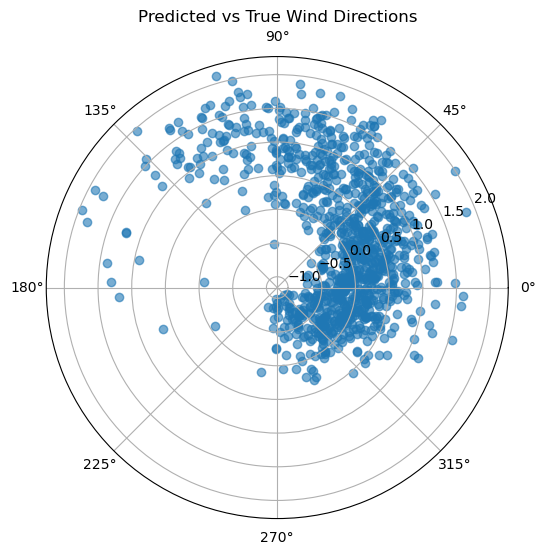

In [22]:

# Evaluate on test set
mu_pred_list, y_true_list = [], []
model.eval()
with torch.no_grad():
    for Xb, yb in test_loader:
        mu_pred_batch = model(Xb).numpy()
        y_true_batch = yb.numpy()
        mu_pred_list.append(mu_pred_batch)
        y_true_list.append(y_true_batch)

mu_pred_all = np.vstack(mu_pred_list)
y_true_all = np.vstack(y_true_list)

# Compute MAE
mae = mean_angular_error(mu_pred_all, y_true_all)
print(f"Mean Angular Error on Test Set: {mae:.4f} radians")

# Polar plot
plt.figure(figsize=(6,6))
plt.subplot(111, polar=True)
plt.scatter(y_true_all, mu_pred_all, alpha=0.6)
plt.title("Predicted vs True Wind Directions")
plt.show()
